In [86]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch
from torch import Tensor, nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install lightning==2.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 6.6 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 664.8/664.8 MB 215.3 MB/s eta 0:00:0100:01Installing collected packages: nvidia-nvjitlink-cu12, nvidia-curand-cu12, nvidia-cufft-cu12, nvidia-cublas-cu12, nvidia-cusparse-cu12, nvidia-cudnn-cu12, nvidia-cusolver-cu12, lightning
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9.90:
      Successfully uninstalled nvidia-curand-cu12-10.3.9.90
  Attempting uninstall: nvidia-cufft-cu12
    Found existing installation: nvidia-cufft-cu12 11.3.3.83
    Uninstal

In [3]:
import lightning as L

In [4]:
!pip install bert-score
from bert_score import score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.7 MB/s eta 0:00:00


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [6]:
path = "/kaggle/input/financial-news-headlines/"
data_cnbc = pd.read_csv(path + "cnbc_headlines.csv").dropna()
data_guar =  pd.read_csv(path + "guardian_headlines.csv").dropna()
data_reut = pd.read_csv(path+ "reuters_headlines.csv").dropna()
data = pd.concat([data_reut['Headlines'],data_cnbc['Headlines'],data_guar['Headlines']])

In [7]:
from sklearn.model_selection import train_test_split
train_texts, test_texts = train_test_split(list(data), test_size=0.1, random_state=2)

In [30]:
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)

In [9]:
class FinancialNewsDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        return text

In [10]:
train_data = FinancialNewsDataset(train_texts)
test_data = FinancialNewsDataset(test_texts)

In [11]:
len(train_texts)

48033

In [12]:
def collate_fn(
    tokenizer: AutoTokenizer, batch: list[str]
) -> tuple[Tensor, Tensor]:
    encoded_batch = tokenizer.batch_encode_plus(
        batch, padding="longest", return_tensors="pt", return_token_type_ids=False)
    return encoded_batch.to(device)

In [13]:
len(tokenizer)

30873

In [14]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=lambda batch:collate_fn(tokenizer,batch))
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, collate_fn=lambda batch:collate_fn(tokenizer,batch))
batch = next(iter(train_loader))

In [15]:
batch['input_ids'].shape

torch.Size([128, 26])

In [16]:
class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.proj = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.GELU(),             
            nn.LayerNorm(output_dim),    
            nn.Dropout(p=0.05)    
        )

    def forward(self, x, mask=None):
        attn_scores = (self.attn(x)*x.mean(dim=-1, keepdim=True)).sum(dim=-1).squeeze(-1)  # (B, T)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(attn_scores, dim=1)  # (B, T)
        return torch.sum(attn_weights.unsqueeze(-1) * self.proj(x), dim=1)  # (B, H)


at = AttentionPooling(768, 1024).to(device)

In [17]:
x= bert_model(batch['input_ids'], attention_mask=batch['attention_mask']).last_hidden_state

In [18]:
at(x).shape

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

torch.Size([128, 1024])

In [19]:
tgt_seq_len = 13
tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len)

In [20]:
class FactorizedOutput(nn.Module):
    def __init__(self, hidden_dim, vocab_size, factor_dim):
        super(FactorizedOutput, self).__init__()
        #self.proj_down = nn.Linear(hidden_dim, factor_dim, bias=False)
        self.proj_down = nn.Sequential(
            nn.Linear(hidden_dim, factor_dim, bias=False),
            nn.GELU(),             
            nn.LayerNorm(factor_dim),    
            nn.Dropout(p=0.05)    
        )
        self.proj_up = nn.Linear(factor_dim, vocab_size, bias=False)

    def forward(self, x):
        # Down-projection
        x = self.proj_down(x)  # (B, T, factor_dim)
        # Up-projection to vocab size
        logits = self.proj_up(x)  # (B, T, vocab_size)
        return logits

In [95]:
import math


class EncoderDecoderModel(nn.Module):
    def __init__(self, bert_model, hidden_dim=768, num_layers=2, nhead=8, max_length=100, vocab_size=len(tokenizer),dropout=1e-4, sent_dim=1568):
        super().__init__()
        self.bert = bert_model  # ЭНКОДЕР (BERT)
        self.bert.requires_grad_(False)
        self.hidden_dim = hidden_dim
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.sent_dim = sent_dim

        self.act = nn.GELU()


        #self.pos_lin1 = nn.Linear(hidden_dim, hidden_dim)
        #self.pos_lin2 = nn.Linear(hidden_dim, sent_dim)

        self.proj1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),             
            nn.LayerNorm(hidden_dim),    
            nn.Dropout(p=0.01)    
        )
        
        self.proj2 = nn.Sequential(
            nn.Linear(hidden_dim, sent_dim),
            nn.GELU(),             
            nn.LayerNorm(sent_dim),    
            nn.Dropout(p=0.01)    
        )

        self.attn_pool = AttentionPooling(hidden_dim, sent_dim)
      
        self.tgt_projector = nn.Linear(hidden_dim, sent_dim)
        # Декодер
        decoder_layer = nn.TransformerDecoderLayer(d_model=sent_dim, nhead=nhead, dim_feedforward=sent_dim, dropout=dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Выходной слой для предсказания токенов
        self.fc_out = nn.Linear(sent_dim, vocab_size)
        #self.factorized_output = FactorizedOutput(sent_dim, vocab_size, 3*sent_dim//2)

        # Генерация синусоидальных позиционных эмбеддингов
        self.register_buffer("positional_encoding", self.sinusoidal_positional_encoding(max_length, hidden_dim))

    def sinusoidal_positional_encoding(self, seq_length, hidden_dim):
        position = torch.arange(seq_length).unsqueeze(1).float()  # (T, 1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-math.log(10000.0) / hidden_dim))

        pe = torch.zeros(seq_length, hidden_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        return pe.unsqueeze(0).to(device)  # (1, T, H)

    def get_sentence_emb(self, input_ids, attention_mask):
        encoded = self.bert(input_ids, attention_mask=attention_mask).last_hidden_state # (B, T, H)
        pos = self.positional_encoding[:, :input_ids.size(1), :]
        encoded += self.proj1(pos)
        sent_embedding = self.attn_pool(encoded, attention_mask)
        return sent_embedding


    def forward(self, input_ids, attention_mask):
        batch_size, seq_length = input_ids.shape  # (B, T)

        with torch.no_grad():
            sent_emb = self.get_sentence_emb(input_ids, attention_mask)  # (B, S)
            tgt = self.bert.embeddings.word_embeddings(input_ids)

        memory = sent_emb.unsqueeze(1)#torch.stack(memory, dim=1)

        

        # Декодерные входы (позиционные эмбеддинги)
        #tgt = self.tgt_projector(tgt)

        pos = self.positional_encoding[:, :input_ids.size(1), :]
        
        tgt = self.proj2(tgt+pos)

       
        # ПРОГОН ЧЕРЕЗ ДЕКОДЕР

        tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)

        decoder_output = self.transformer_decoder(tgt,
                                                  memory=memory,
                                                  tgt_mask=tgt_mask.bool(),
                                                  tgt_key_padding_mask=(attention_mask==0)
                                                  )  # (B, T, S)



        # ПРОГОН ЧЕРЕЗ ВЫХОДНОЙ ЛИНЕЙНЫЙ СЛОЙ
        token_logits = self.fc_out(decoder_output)  # (B, T, V)

        return token_logits  # (B, T, V)

In [22]:
class LightningAutoencoder(L.LightningModule):
    def __init__(self, model, learning_rate=1e-4, tokenizer=tokenizer):
        super().__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)
        self.learning_rate = learning_rate
        self.tokenizer = tokenizer

    def get_sentence_emb(self, batch):
        return self.model.get_sentence_emb(batch['input_ids'], batch['attention_mask'])

    def forward(self, batch):
        return self.model(batch['input_ids'], batch['attention_mask'])

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask = batch['input_ids'], batch['attention_mask']

        outputs = self.model(input_ids, attention_mask)

        targets = input_ids[:, 1:].contiguous()  # Сдвигаем цель на 1 вправо
        outputs = outputs[:, :-1, :]  # Убираем последний предсказанный токен

        loss = self.criterion(outputs.reshape(-1, self.model.vocab_size), targets.reshape(-1))

        sent_emb = self.get_sentence_emb(batch)
        #loss += 0.1*paraphrase_loss(5, outputs, sent_emb, attention_mask, model.model)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        accuracy = torch.logical_and(targets == outputs.argmax(dim=-1), attention_mask[:, 1:]).sum() / attention_mask.sum()
        self.log("train_accuracy", accuracy.item(), on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask = batch['input_ids'], batch['attention_mask']

        outputs = self.model(input_ids, attention_mask)

        targets = input_ids[:, 1:].contiguous()
        outputs = outputs[:, :-1, :]

        loss = self.criterion(outputs.reshape(-1, self.model.vocab_size), targets.reshape(-1))

        sent_emb = self.get_sentence_emb(batch)
        #loss += 0.1*paraphrase_loss(5, outputs, sent_emb, attention_mask, model.model)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        accuracy = torch.logical_and(targets == outputs.argmax(dim=-1), attention_mask[:, 1:]).sum() / attention_mask.sum()
        self.log("val_accuracy", accuracy.item(), on_step=False, on_epoch=True, prog_bar=True)
        if batch_idx%50 == 0:
            output, pred_tokens = self.generate_from_embedding(sent_emb)
            input = self.tokenizer.batch_decode(input_ids, skip_special_tokens=True)
            P, R, F1 = score(output, input, lang='en', model_type='microsoft/deberta-xlarge-mnli')
            self.log('val_BERTScore F1:', F1.mean().item(),on_step=False, on_epoch=True, prog_bar=True)
            output_emb = self.model.get_sentence_emb(pred_tokens, (pred_tokens!=0).int())
            self.log('cos_sim', F.cosine_similarity(output_emb , sent_emb, dim=-1).mean().item(),on_step=False, on_epoch=True, prog_bar=True)
        
        return {
            "loss": loss,
            "preds": outputs,
        }

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        # давайте кроме оптимизатора создадим ещё расписание для шага оптимизации
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[5, 10, 15],
                gamma=0.1,
            ),
        }


    @torch.inference_mode()
    def generate_from_embedding(self, sent_emb: torch.Tensor, max_len: int = 70):
        self.eval()

        B, S = sent_emb.shape

        #memory = []
        #for linear_layer in self.model.linear_layers:
            #memory.append(linear_layer(sent_emb))

        #memory = torch.stack(memory, dim=1)
        memory = sent_emb.unsqueeze(1)

        tgt_ids = torch.full((B, 1), self.tokenizer.cls_token_id, dtype=torch.long, device=device)
        finished = torch.zeros(B, dtype=torch.bool, device=device)

        for _ in range(max_len):
            t = tgt_ids.size(1)

            pos_emb = self.model.positional_encoding[:, :t, :]

            tgt = self.model.bert.embeddings.word_embeddings(tgt_ids)

            tgt = self.model.proj2(tgt+pos_emb)

            tgt_mask = nn.Transformer.generate_square_subsequent_mask(t).to(device)

            decoder_output = self.model.transformer_decoder(tgt,
                                                      memory=memory,
                                                      tgt_mask=tgt_mask.bool(),
                                                      )
            logits = self.model.fc_out(decoder_output[:,-1,:])

            next_token = torch.argmax(logits, dim=-1, keepdim=True)

            #next_token = torch.multinomial(logits, 1)
            

            tgt_ids = torch.cat([tgt_ids, next_token], dim=-1)


            finished = finished | (next_token.squeeze(1) == self.tokenizer.sep_token_id)
            if finished.all():
                break


        return self.tokenizer.batch_decode(tgt_ids, skip_special_tokens=True), tgt_ids


In [23]:
def top_k(batch, attention_mask, k=5):
    attention_mask = batch['attention_mask']
    logits = model(batch)[:,:-1,:]  # Замените B, T, V на соответствующие значения
    targets = input_ids[:,1:]  # Целевые индексы токенов
    
    # Получаем топ-5 предсказаний для каждого токена
    top5_probs, top5_indices = torch.topk(logits, k, dim=-1)  # top5_indices имеет форму [B, T, 5]
    
    # Сравниваем целевые токены с топ-5 предсказаниями
    # Добавляем дополнительное измерение к targets для сравнения
    targets_expanded = targets.unsqueeze(-1)  # Форма: [B, T, 1]
    
    # Проверяем, совпадает ли целевой токен с одним из топ-5 предсказаний
    correct = (top5_indices == targets_expanded).any(dim=-1)  # Форма: [B, T], значения True/False
    
    # Вычисляем точность: среднее значение по всем токенам
    top5_accuracy = torch.logical_and(correct, attention_mask[:, 1:]).sum() / attention_mask.sum()
    
    print(f"Top-5 Accuracy: {top5_accuracy:.4f}")


In [24]:
encoder_decoder_model = EncoderDecoderModel(bert_model, sent_dim=2560).to(device)
model = LightningAutoencoder(encoder_decoder_model).to(device)

In [25]:
from lightning.pytorch.callbacks.model_summary import summarize

print(summarize(model,2))

  | Name                      | Type                | Params | Mode 
--------------------------------------------------------------------------
0 | model                     | EncoderDecoderModel | 327 M  | train
1 | model.bert                | BertModel           | 109 M  | eval 
2 | model.act                 | GELU                | 0      | train
3 | model.proj1               | Sequential          | 592 K  | train
4 | model.proj2               | Sequential          | 2.0 M  | train
5 | model.attn_pool           | AttentionPooling    | 2.6 M  | train
6 | model.tgt_projector       | Linear              | 2.0 M  | train
7 | model.transformer_decoder | TransformerDecoder  | 131 M  | train
8 | model.fc_out              | Linear              | 79.1 M | train
9 | criterion                 | CrossEntropyLoss    | 0      | train
--------------------------------------------------------------------------
217 M     Trainable params
109 M     Non-trainable params
327 M     Total params
1,308.281 

In [26]:
from lightning.pytorch.loggers import TensorBoardLogger

In [27]:
#1)val_loss=2.450, val_accuracy=0.539, train_loss=1.010, train_accuracy=0.734

In [97]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    ModelCheckpoint(
        filename="{epoch}-{val_loss:.2f}",
        monitor="val_loss",
        mode="min",
        save_top_k=3,
        save_last=True,
    )
]

ERROR! Session/line number was not unique in database. History logging moved to new session 29


In [ ]:
trainer = L.Trainer(
    max_epochs=15,
    accelerator="auto",
    logger=L.pytorch.loggers.CSVLogger(save_dir=".", version = "base"),#TensorBoardLogger(save_dir="tb_logs"),
    callbacks=callbacks
)

trainer.fit(model, train_loader, test_loader)



INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | EncoderDecoderModel | 327 M  | train
1 | criterion | CrossEntropyLoss    | 0      | train
----------------------------------------------------------
217 M     Trainable params
109 M     Non-trainable params
327 M     Total params
1,308.281 Total estimated model params size (MB)
52        Modules in train mode
228       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.04G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.04G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [31]:
it = iter(test_loader)

In [1]:
batch = next(it).to(device)
input_ids = batch['input_ids']
attention_mask = batch['attention_mask']

input = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

NameError: name 'it' is not defined

In [76]:
top_k(batch, attention_mask, k=5)

Top-5 Accuracy: 0.7379


In [34]:
model.to(device)

LightningAutoencoder(
  (model): EncoderDecoderModel(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30873, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768,

In [2]:
embedding_matrix = model.model.bert.embeddings.word_embeddings.weight.to(device)

NameError: name 'model' is not defined

In [24]:
def generate(probs, embedding_matrix, n_samples=10):
  data = []
  for i in range(n_samples):
    p = (-torch.log(-torch.log(torch.rand(probs.shape,device=device))))
    T = 0.5
    alpha = F.softmax((p+torch.log(probs))/T, dim=-1)
    gen = torch.matmul(alpha, embedding_matrix)
    cls_tok = embedding_matrix[tokenizer.cls_token_id].expand(gen.size(0),1,gen.size(-1)).to(device)
    gen = torch.cat([cls_tok, gen], dim=1)
    data.append(gen)
    

  res = torch.stack(data,0)
  return res

In [23]:
#оптимизуруем cos_sim между sent_emb1, sent_emb2,
#полученные из encoder для tokens и сгенерированных emb из выхода 
def paraphrase_loss(n_samples, logits, sent_emb, mask, model):
  probs = F.softmax(logits, dim=-1)
  gen_samples = generate(probs, model.bert.embeddings.word_embeddings.weight, n_samples)
  gen_sent_emd = []
  pos = model.positional_encoding[:, :logits.size(1)+1, :]
  for sample in gen_samples:
    encoded = sample + model.proj1(pos)
    emb = model.attn_pool(encoded, mask)
    gen_sent_emd.append(emb) 
  gen_sent_emd  = torch.stack(gen_sent_emd,0)
  loss = torch.tensor(1,device=device)-(F.normalize(gen_sent_emd, dim=-1)*F.normalize(sent_emb, dim=-1)).sum(-1).mean()
  return loss

In [84]:
paraphrase_loss(3, logits[:,:-1,:], sent_emb, attention_mask, model.model)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [77]:
sent_emb = model.get_sentence_emb(batch)

In [254]:
input_ids.shape

torch.Size([64, 26])

In [78]:
output, tok = model.generate_from_embedding(sent_emb, max_len=100)
output_emb = model.model.get_sentence_emb(tok,tok!=0)

In [69]:
 F.cosine_similarity(output_emb , sent_emb, dim=-1).mean().item() 

0.7926852703094482

In [79]:
from bert_score import score

P, R, F1 = score(output, input, lang='en', model_type='microsoft/deberta-xlarge-mnli')
print('BERTScore F1:', F1.mean().item())


BERTScore F1: 0.6381648182868958


In [41]:
list(zip(input, output))

[('bank of america to pay $ 7. 23 million for mutual fund overcharges : finra',
  'bank of america to pay $ 6. 7 million for fund $ 16 million : fund manager'),
 ('zynga to buy turkish mobile game - maker peak for $ 1. 8 billion',
  'chinese music maker to buy mobile - mobile maker for $ 1. 4 billion deal'),
 ('intel buys israeli ai startup habana labs for $ 2 billion',
  'intel buys israel state cauda for $ 2 billion israel'),
 ('business live china fuels trade war fears with new tariffs on us goods - as it happened',
  'business live us tariffs on trade war fears with us - china tariffs - as it happened'),
 ('eu worried fiat - psa deal may hit competition in vans',
  'eu - fiat chrysler deal may hit eu in eu, eu'),
 ('spacex looks to raise $ 507 million in a new funding round : filing',
  'boeing looks to raise $ 50 billion in a new funding round : filing a week'),
 ('exclusive : wells fargo shifts energy bankers to focus on bankruptcies',
  'exclusive : wells fargo shifts to focus o

In [80]:
list(zip(input, output))

[('factbox : which hbo subscribers will get hbo max at no extra charge?',
  "at all uk : which willn't get free for their streaming?"),
 ('extend coronavirus wage subsidies or risk delayed redundancies, firms warn',
  'coronavirus lockdowns or loss, say - cost cuts threatens'),
 ('silicon valley, wall street taking notes on spotify debut',
  'wall street, wall street takes on hold on new round'),
 ('u. s. import prices post largest drop in more than one - and - a - half years',
  'u. s. oil prices post more than one - and a - half a - half in a year'),
 ('straight from the lip : how kylie jenner is close to becoming a billionaire at 20',
  'from the age of sky : how is a jolliant at thomas cooker at the sky'),
 ('pg & e falls further after s & p cuts credit rating to junk',
  's & p cuts credit rating to credit rating after s & p falls into'),
 ('india to issue new safety rules for a320neos with pratt & whitney engines',
  'new pratt to issue new engines for pratt enginess with airbus 

In [178]:
list(zip(input, output))

[("giraffe and ed's easy diner branch closures put 340 jobs at risk",
  "sogan marcus and frills branch's branches put up branches and lost jobs"),
 ('as brazilian payment apps multiply, some warn of a shakeout',
  'as chinese economy shrugs, some of some cheer ahead'),
 ("aeva signs sensor deal with audi's self - driving unit",
  "audi backs automated deal with self - driving unit's self driving"),
 ('u. s. house technology panel heads seeks delay in 5g spectrum auction',
  'u. s. house panel panel seeks 5g panel decision in 5g rollout'),
 ("nyse, spotify's market debut, and the swiss miss",
  "spotify, nasdaq's debut and the market debut, spotify"),
 ('boeing jet deliveries sink to just four in may',
  'jet deliveries sink to boeing deliveries in two days'),
 ("trump's ambitious fannie, freddie overhaul faces hurdles",
  "trump's trump, freddie faces new ceo hurdle"),
 ('u. s. grocers add plexiglass sneeze guards to protect cashiers from coronavirus',
  'u. s. lawmakers hand swelwsas

In [48]:
list(zip(input, output))

[('hsbc to let customers block spending on gambling websites',
  'mps told to let customers block gambling on gambling customers'),
 ('big brands dive into esports to court youth market : nielsen',
  'jeansworld may face gries to retail market : media divisionsss'),
 ('airline executives brace for oil price turbulence at sydney gathering',
  'ryanair executives brace for rising oil price during pandemic braces'),
 ('consumers support u. s. economy as business spending slumps',
  'u. s. economy business spending as economy smashes economy strengthen economy'),
 ('swatch ceo says china sales rise but global situation still grim',
  'china ceo says global sales boom but business owners still cautious not'),
 ('britain - based airlines seek industry tax breaks in coronavirus battle',
  'american - owned airlines seek tax - in britain from coronavirus cases unions'),
 ('equities fall after fed keeps rates on hold, dollar up',
  'dollar, bonds keep up slightly after fed rate rises falls'),
 

In [59]:
list(zip(input, output))

[('bank of america to pay $ 7. 23 million for mutual fund overcharges : finra',
  'pay for $ 2. 6 million to pay for pay fees : wsj cramer says'),
 ('zynga to buy turkish mobile game - maker peak for $ 1. 8 billion',
  'chinese media to buy $ 1. 6 billionaire for $ 1. 4 billion deal'),
 ('intel buys israeli ai startup habana labs for $ 2 billion',
  "intel buys $ 1 billion in india's gakea"),
 ('business live china fuels trade war fears with new tariffs on us goods - as it happened',
  'business live us tariffs on china trade war fears of us - as it happened - as it'),
 ('eu worried fiat - psa deal may hit competition in vans',
  'fiat chrysler may push eu - fiat chrysler deal in may'),
 ('spacex looks to raise $ 507 million in a new funding round : filing',
  'explainer aims to raise $ 2 billion in funding in funding : filing funding'),
 ('exclusive : wells fargo shifts energy bankers to focus on bankruptcies',
  'jpmorgan hires jpmorgan hires focus on new banking banking business :')

In [58]:
!ls lightning_logs/base

checkpoints  hparams.yaml  metrics.csv


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [94]:
encoder_decoder_model = EncoderDecoderModel(bert_model).to(device)
model = LightningAutoencoder(encoder_decoder_model).to(device)

last_checkpoint_path = Path("tb_logs/lightning_logs/version_2/checkpoints/epoch=13-val_loss=2.45.ckpt")
trainer.validate(
    model,
    test_loader,
    ckpt_path=last_checkpoint_path,
)

INFO: Restoring states from the checkpoint path at tb_logs/lightning_logs/version_2/checkpoints/epoch=13-val_loss=2.45.ckpt


FileNotFoundError: Checkpoint file not found: tb_logs/lightning_logs/version_2/checkpoints/epoch=13-val_loss=2.45.ckpt

In [96]:
encoder_decoder_model = EncoderDecoderModel(bert_model, sent_dim=1024).to(device)
model2 = LightningAutoencoder(encoder_decoder_model).to(device)

In [ ]:
trainer = L.Trainer(
    max_epochs=15,
    accelerator="auto",
    logger=L.pytorch.loggers.CSVLogger(save_dir=".", version = "base2"),#TensorBoardLogger(save_dir="tb_logs"),
    callbacks=callbacks
)

trainer.fit(model2, train_loader, test_loader)



INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./lightning_logs/base2 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                | Params | Mode
---------------------------------------------------------
0 | model     | EncoderDecoderModel | 165 M  | eval
1 | criterion | CrossEntropyLoss    | 0      | eval
---------------------------------------------------------
56.2 M    Trainable params
109 M     Non-trainable params
165 M     Total params
663.800   Total estimated model params size (MB)
0         Modules in train mode
280       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [91]:
import numpy as np
import seaborn as sns
metrics_df = pd.read_csv(f"./lightning_logs/base/metrics.csv") #1568

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

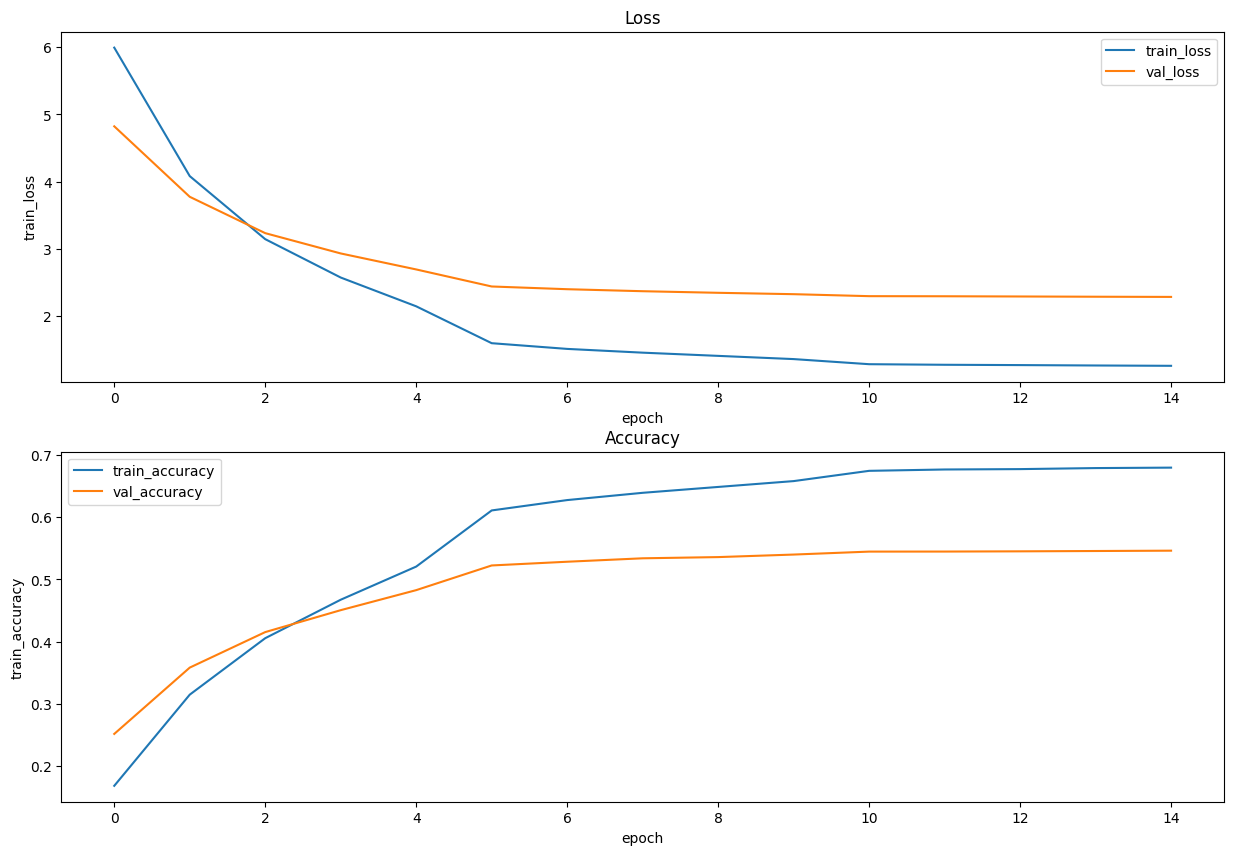

In [92]:
#2560
graph(metrics_df)

In [47]:
import numpy as np
import seaborn as sns
metrics_df1 = pd.read_csv(f"./lightning_logs/base/metrics.csv") #1568
metrics_df2 = pd.read_csv(f"./lightning_logs/base2/metrics.csv") #768

In [156]:
metrics_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,cos_sim,epoch,step,train_accuracy,train_loss,val_BERTScore F1:,val_accuracy,val_loss
0,0.786126,0,750,NaN,NaN,0.475090,0.317616,4.324810
1,NaN,0,750,0.225657,5.485415,NaN,NaN,NaN
2,0.820961,1,1501,NaN,NaN,0.565379,0.402843,3.431703
3,NaN,1,1501,0.368102,3.678375,NaN,NaN,NaN
4,0.820350,2,2252,NaN,NaN,0.599186,0.451186,2.998091
5,NaN,2,2252,0.441839,2.883338,NaN,NaN,NaN
6,0.823321,3,3003,NaN,NaN,0.621639,0.479571,2.771978
7,NaN,3,3003,0.499441,2.355045,NaN,NaN,NaN
8,0.824565,4,3754,NaN,NaN,0.631267,0.500474,2.626229
9,NaN,4,3754,0.547787,1.977283,NaN,NaN,NaN


In [83]:
def graph(metrics_df):
    fig, ax = plt.subplots(2, 1, figsize=(15, 10))

    sns.lineplot(data=metrics_df, x='epoch', y='train_loss', ax=ax[0], label='train_loss')
    sns.lineplot(data=metrics_df, x='epoch', y='val_loss', ax=ax[0], label='val_loss')
    ax[0].set_title("Loss")
    ax[0].legend()


    sns.lineplot(data=metrics_df, x='epoch', y='train_accuracy', ax=ax[1], label='train_accuracy')
    sns.lineplot(data=metrics_df, x='epoch', y='val_accuracy', ax=ax[1], label='val_accuracy')
    ax[1].set_title("Accuracy")
    ax[1].legend()

   
    plt.show()

#graph(metrics_df1)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

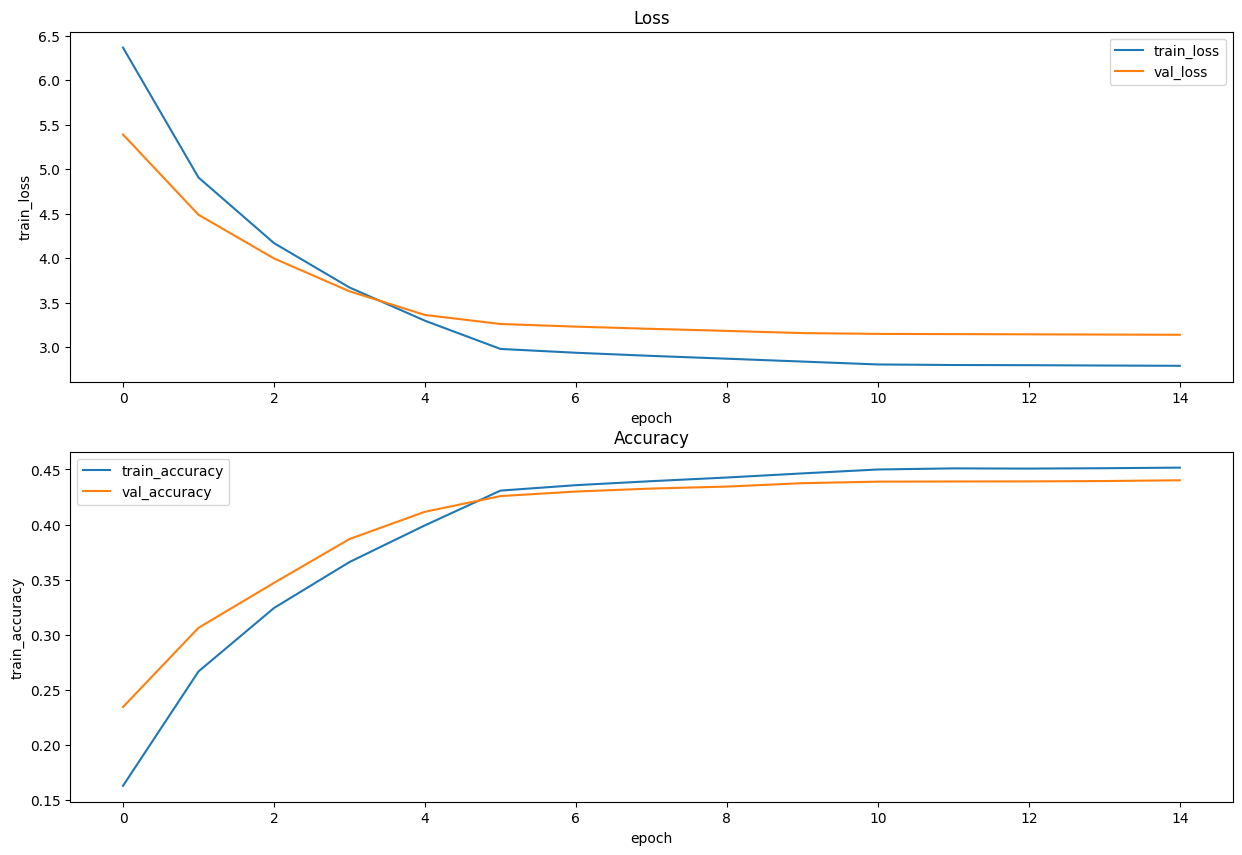

In [51]:
graph(metrics_df2)

In [62]:
metrics_df1

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,cos_sim,epoch,step,train_accuracy,train_loss,val_BERTScore F1:,val_accuracy,val_loss
0,0.713771,0,375,NaN,NaN,0.405096,0.258543,4.897727
1,NaN,0,375,0.184078,5.958757,NaN,NaN,NaN
2,0.787770,1,751,NaN,NaN,0.495027,0.358919,3.843801
3,NaN,1,751,0.313272,4.234971,NaN,NaN,NaN
4,0.814405,2,1127,NaN,NaN,0.540008,0.413512,3.332320
5,NaN,2,1127,0.384170,3.416417,NaN,NaN,NaN
6,0.818237,3,1503,NaN,NaN,0.569574,0.442240,3.053838
7,NaN,3,1503,0.437474,2.869020,NaN,NaN,NaN
8,0.824372,4,1879,NaN,NaN,0.585184,0.471357,2.804953
9,NaN,4,1879,0.481607,2.465209,NaN,NaN,NaN


In [63]:
metrics_df2

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,cos_sim,epoch,step,train_accuracy,train_loss,val_BERTScore F1:,val_accuracy,val_loss
0,0.784567,0,375,NaN,NaN,0.395926,0.234438,5.389074
1,NaN,0,375,0.162939,6.364359,NaN,NaN,NaN
2,0.811964,1,751,NaN,NaN,0.458195,0.306260,4.488917
3,NaN,1,751,0.266680,4.906623,NaN,NaN,NaN
4,0.813567,2,1127,NaN,NaN,0.507991,0.347015,3.998417
5,NaN,2,1127,0.324239,4.170551,NaN,NaN,NaN
6,0.822618,3,1503,NaN,NaN,0.539982,0.386799,3.629633
7,NaN,3,1503,0.365946,3.672199,NaN,NaN,NaN
8,0.833595,4,1879,NaN,NaN,0.548012,0.411548,3.363951
9,NaN,4,1879,0.399242,3.299303,NaN,NaN,NaN


In [44]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'

    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [55]:
#768  val_loss=3.520, val_accuracy=0.405, val_BERTScore F1:=0.560, cos_sim=0.754, train_loss=3.310, train_accuracy=0.403

In [64]:
encoder_decoder_model = EncoderDecoderModel(bert_model, sent_dim=4096).to(device)
model = LightningAutoencoder(encoder_decoder_model).to(device)

In [ ]:
trainer = L.Trainer(
    max_epochs=15,
    accelerator="auto",
    logger=L.pytorch.loggers.CSVLogger(save_dir=".", version = "base3"),#TensorBoardLogger(save_dir="tb_logs"),
    callbacks=callbacks
)

trainer.fit(model, train_loader, test_loader)



In [ ]:
torch.save(model.state_dict(),'model_scripted.pt')